In [17]:
# load packages
import numpy as np 
import h5py
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

### Functions for Data Processing

In [18]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
################################################################################
# comine real and imaginary numbers, only 1st component - For average across pre and post
def CombineRealImg(x, NumHarms):
    [NumCols, NumTrials] = np.shape(x) # 24 x 78-80
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    pre = x[:,:CondCutoff] # 24 x 39 - 40 depends ...
    post = x[:,CondCutoff:]
    AmpPerBin = np.ones((DomainCutoff,NumHarms)) # [bins (2f1 then 4f1)] X [pre /post] \ 12 x 2
    for RowInd in range(DomainCutoff):
        ################ combining data generated from real and imaginary comp (1st half of cols and last half)
        AmpPerBin[RowInd,0] = np.hypot(np.nanmean(pre[RowInd,:]),np.nanmean(pre[RowInd+DomainCutoff,:])) # 12 x 78 PRE
        AmpPerBin[RowInd,1] = np.hypot(np.nanmean(post[RowInd,:]),np.nanmean(post[RowInd+DomainCutoff,:])) # 12 x 78 POST
    return AmpPerBin # single array output

In [19]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4
dk_labs = ['attnL F1','attnL F2','attnR F1','attnR F2',]
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']

In [20]:
x = sns.color_palette("husl", 8)
y = sns.color_palette("hls", 8)

In [21]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AllSubjSweepRCA\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[0] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllRCAData_20240209_133825.pkl']
Current WD: D:\AttnXV3_analysis\RCA_F1\AllSubjSweepRCA\AllRCAData_20240209_133825.pkl
Does File #1 Exist? True


In [22]:
SaveFigDir = 'D:\\AttnXV3_analysis\\TwoSessionPlots_LTP\\'
SubFoldName = 'CRF_plots' # can change folder name to add to another folder now
newPath = os.path.join(SaveFigDir,SubFoldName)
if not os.path.exists(newPath):
    os.makedirs(newPath)
print('Path to Save Figures is:',newPath)

Path to Save Figures is: D:\AttnXV3_analysis\TwoSessionPlots_LTP\CRF_plots


In [23]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())

dict_keys(['FullSessSubjNames', 'DataNotes', 0, 1, 2, 3])


In [24]:
SubName = loadData['FullSessSubjNames']
NumSubs = len(SubName)
txt = loadData['DataNotes']
print(txt)
### ... import actual data ...###
data_inds = list(loadData.keys())[2:6]
print(data_inds)
data = {key: loadData[key] for key in data_inds}

['0&1 attnL[f1/f2] and 2&3 attR[f1/f2]']
[0, 1, 2, 3]


In [25]:
data_out = {}
for data_set_ind in range(4):
    data_out[data_set_ind] = {}  # Initialize inner dictionary for data_set_ind
    for i in range(NumSubs):
        data_out[data_set_ind][i] = CleanRCA(np.array(data[data_set_ind][i]))

#### Combine Real and Imaginary Data and Save

In [26]:
avgCRF = {}
for data_set_ind in range(4):
    avgCRF[data_set_ind] = {}  # Initialize inner dictionary for data_set_ind
    for i in range(NumSubs):
        ds = np.array(data[data_set_ind][i])
        dIn = np.squeeze(ds[:,0,:])
        avgCRF[data_set_ind][i] = CombineRealImg(dIn,NumHarms = 2) # 12 x 2 array

In [27]:
# set save data dir 
# Set directory to save NR Data in ..new folder
SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'AllCondCRF_AllSess' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
MatLabFileN = f'{FileOutName}_{fdnt}.mat'

NewFileNPath = os.path.join(SaveDataDir,FileN)
Mat_NewFileNPath = os.path.join(SaveDataDir, MatLabFileN)

print('Full New File Dir: ', NewFileNPath)
print('Where matlab file will be stored',Mat_NewFileNPath )

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  D:\AttnXV3_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240213_1141.pkl
Where matlab file will be stored D:\AttnXV3_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240213_1141.mat
Path to Save File is: D:\AttnXV3_analysis\RCA_F1\AvgCRFs\


##### Save All Original Contrast Response Functions into a .pkl file

In [28]:
# add another personal voice memo ...
Note = ['This file contains all subjects who did both sessions, avg of CRF [12x2] array, original crfs']

DictOut = {}
DictOut['Data'] = avgCRF
DictOut['SubNames'] = SubName
DictOut['VoiceMemo'] = Note
DictOut['DictMainKeys'] = dk_labs
DictOut['ContLevs'] = contrast_levels
DictOut['crfLabs'] = contrast_levels_labs

### Save Data

In [29]:
saveFile = 'y'

if saveFile == 'y':
 
 scipy.io.savemat(Mat_NewFileNPath,DictOut)

 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DictOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    # save as .mat file or .csv file to import into matlab 
    
    print('Average CRF Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Saved! :))


#### Visualize Data - can only plot per harmonic right now 

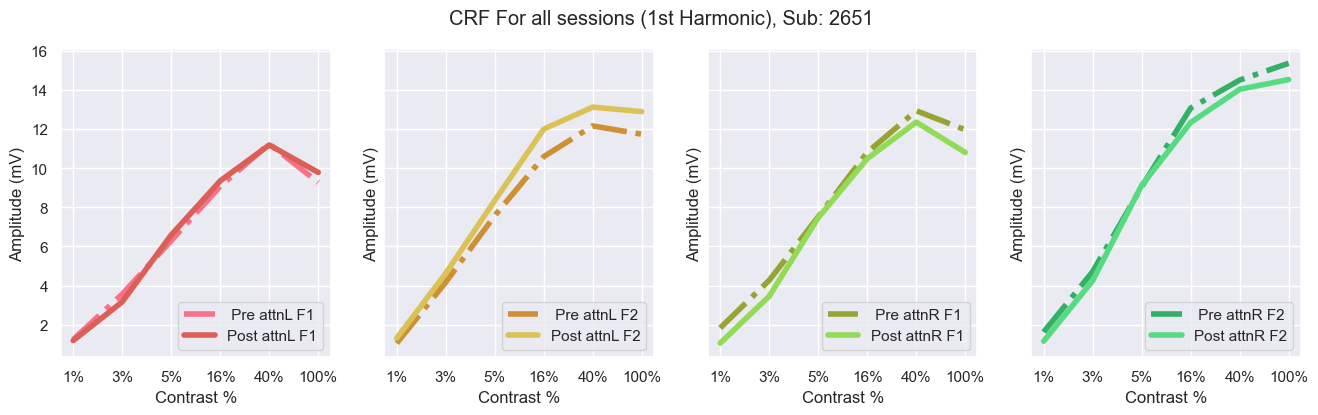

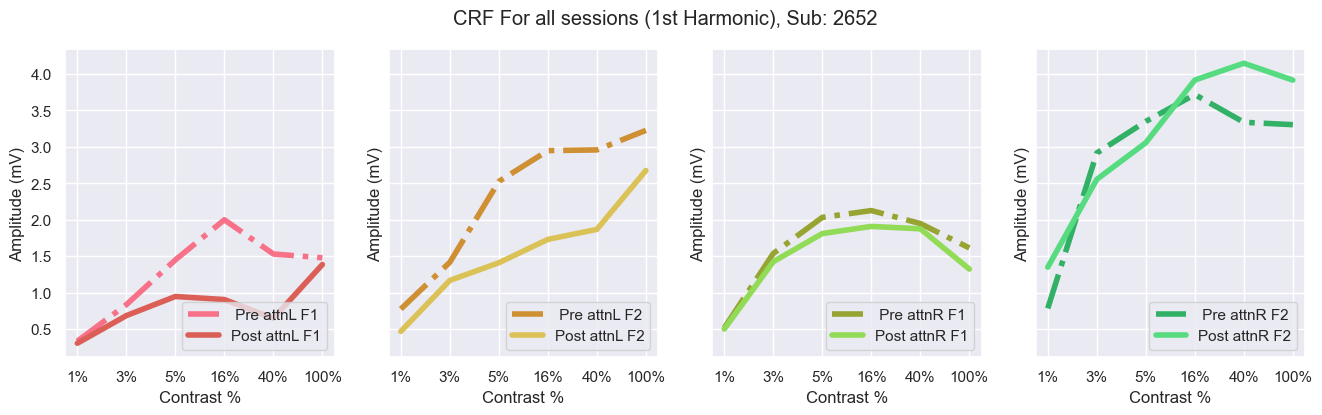

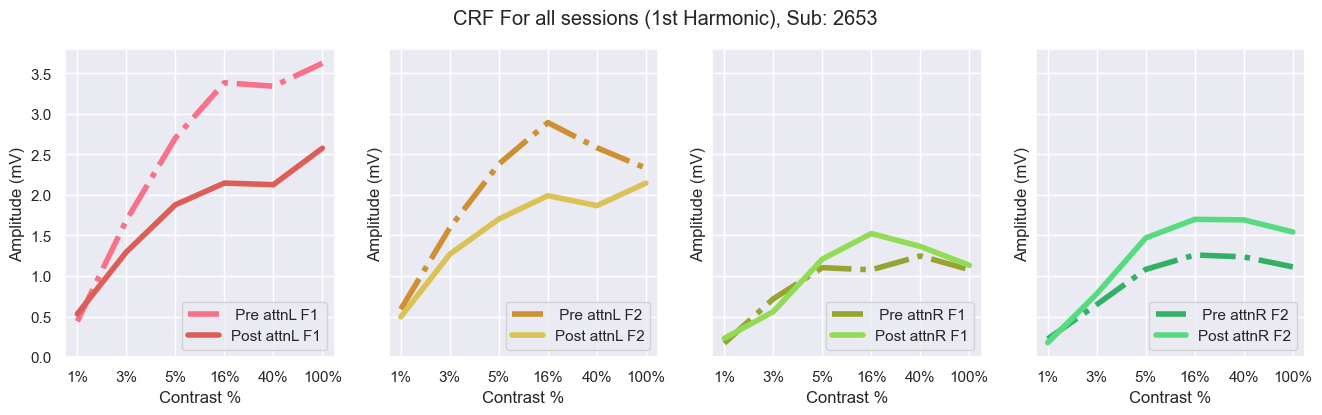

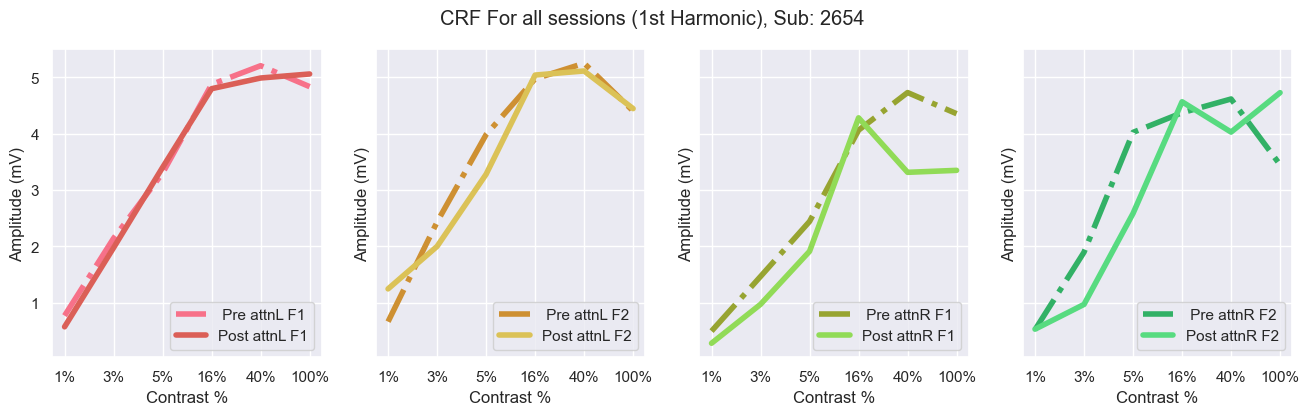

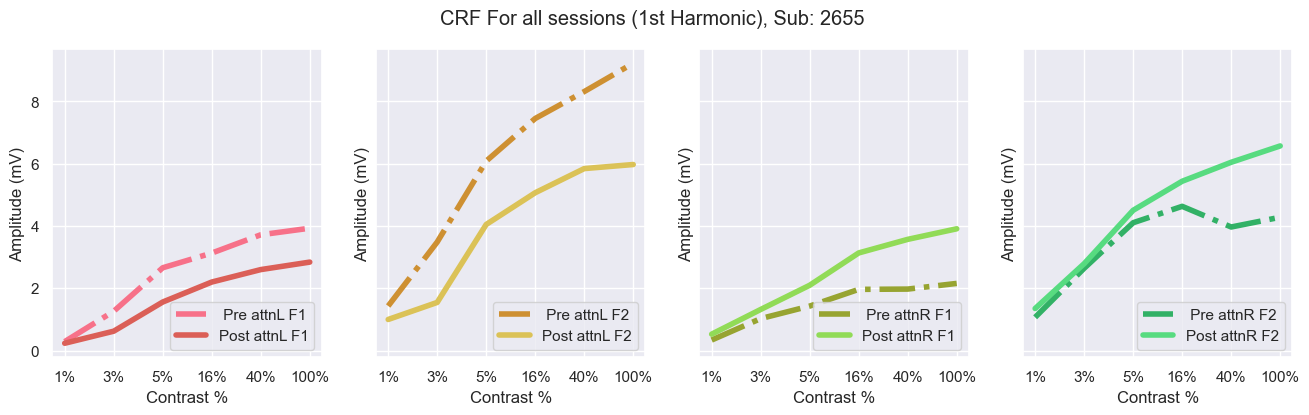

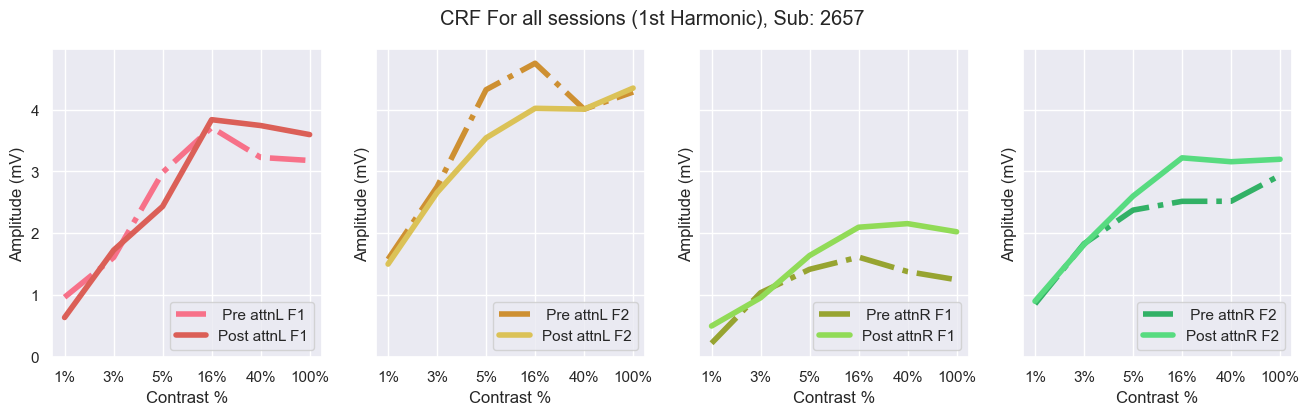

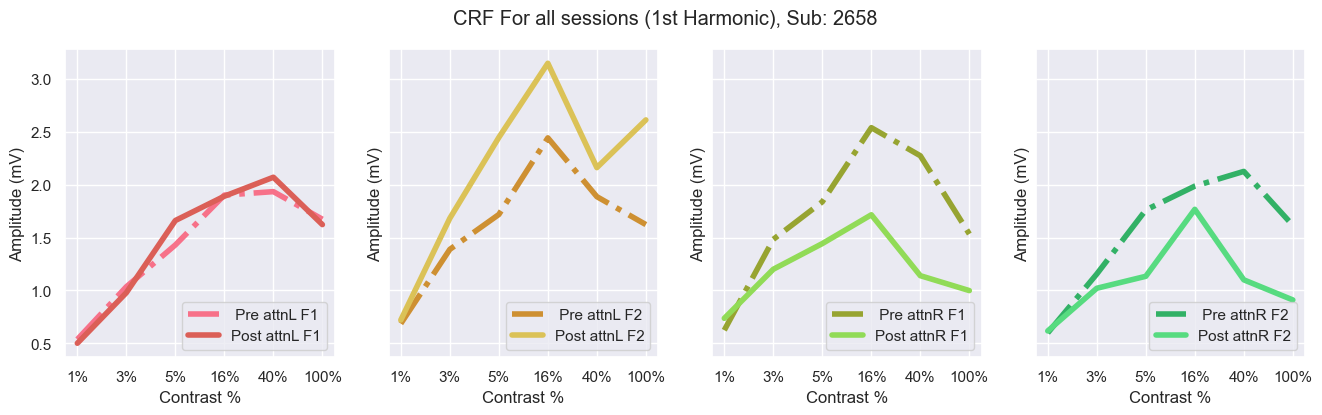

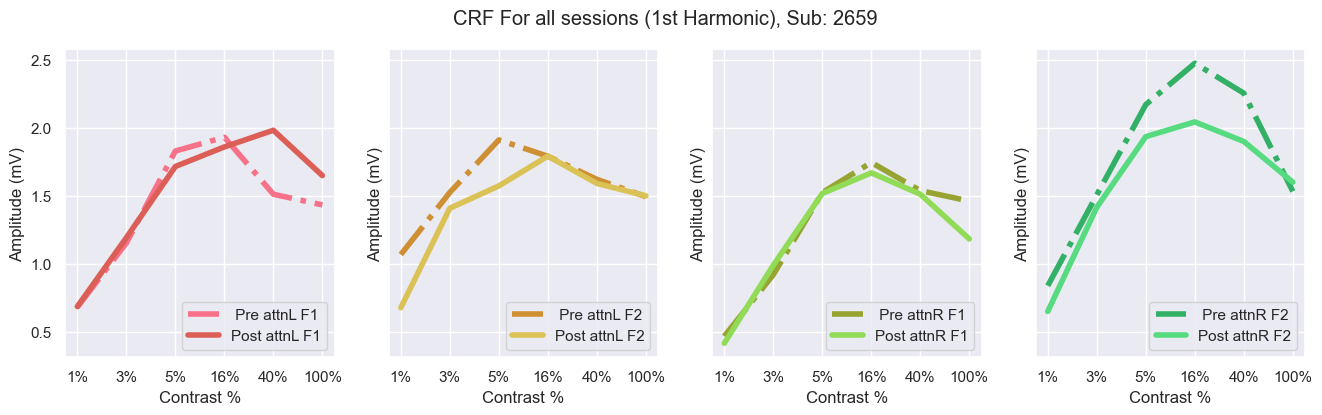

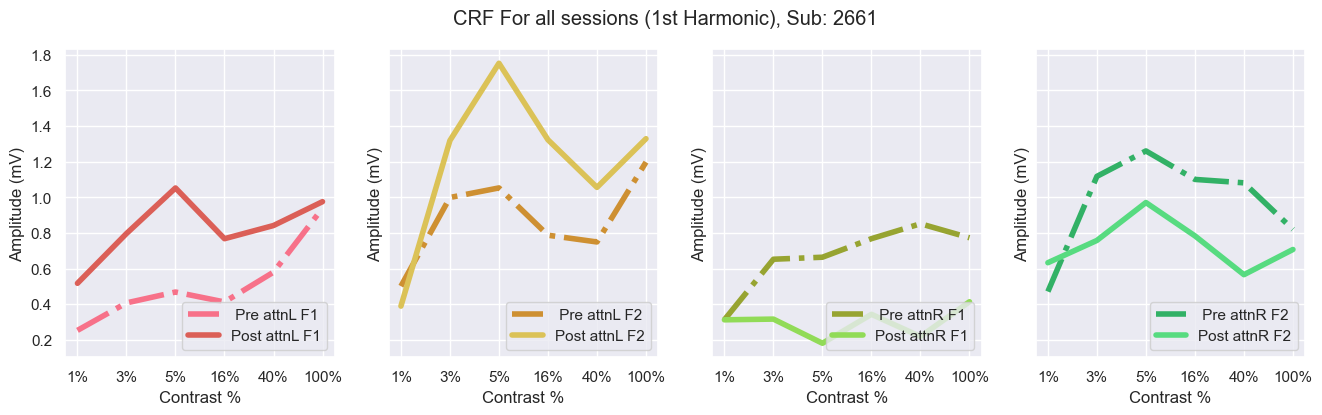

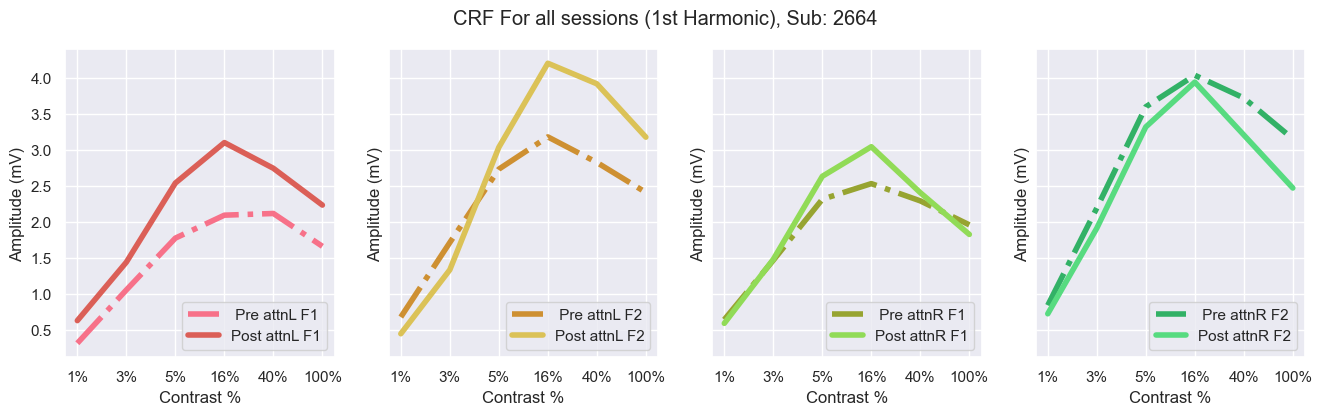

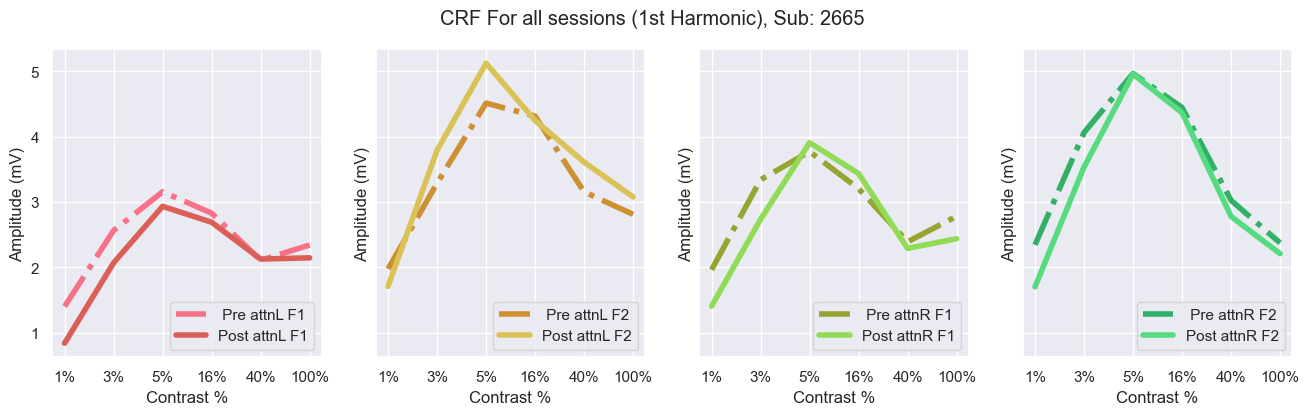

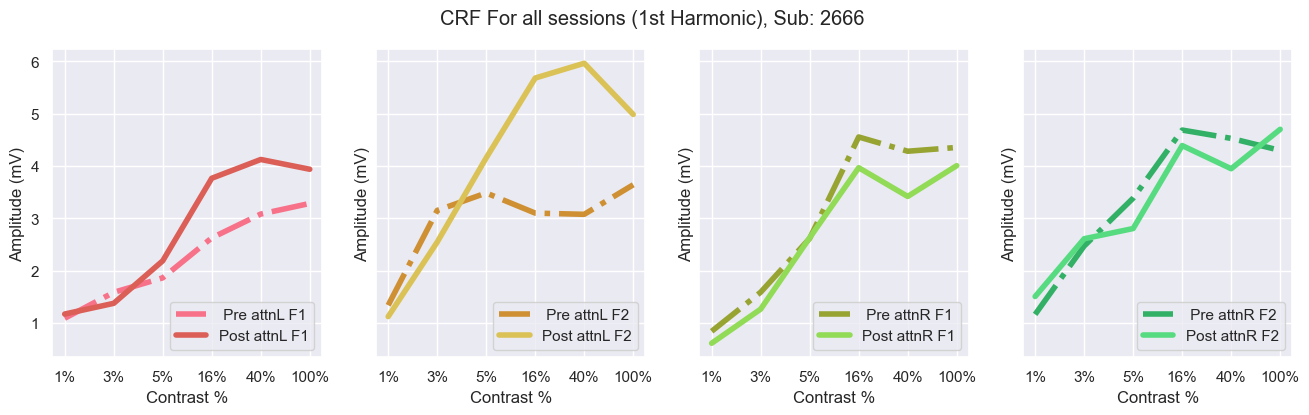

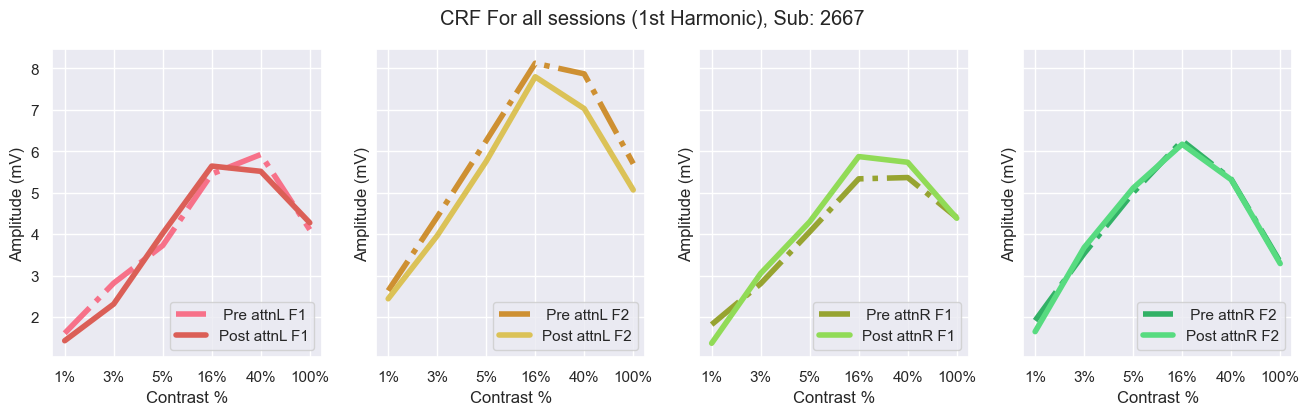

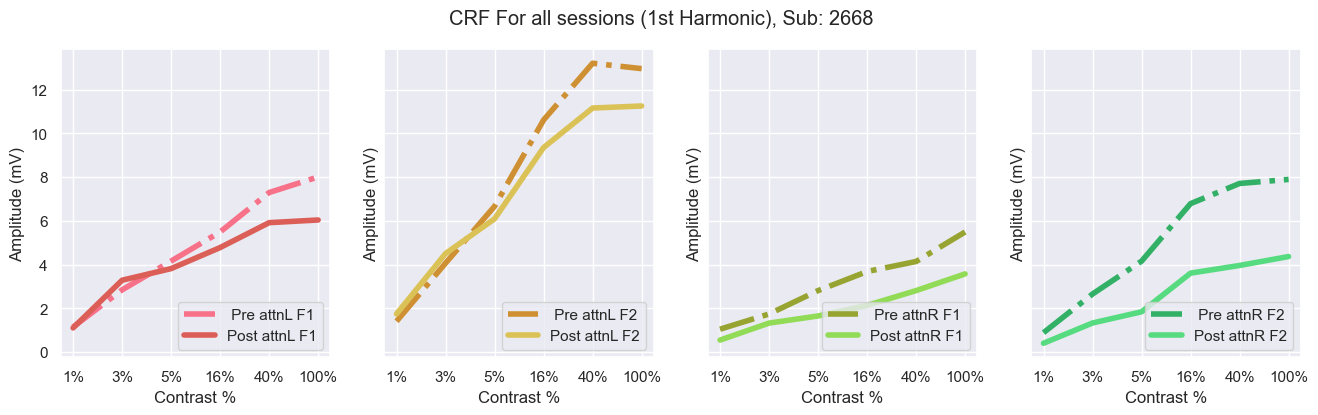

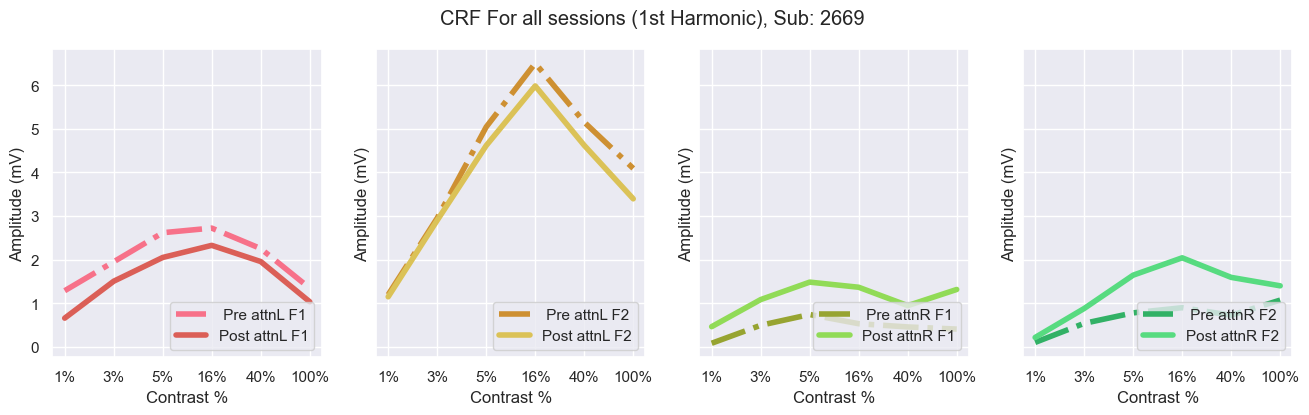

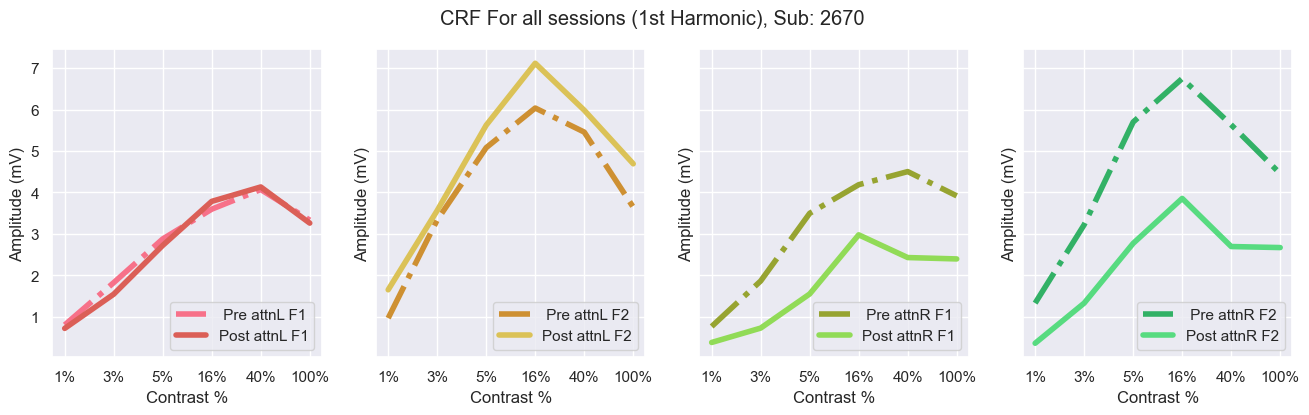

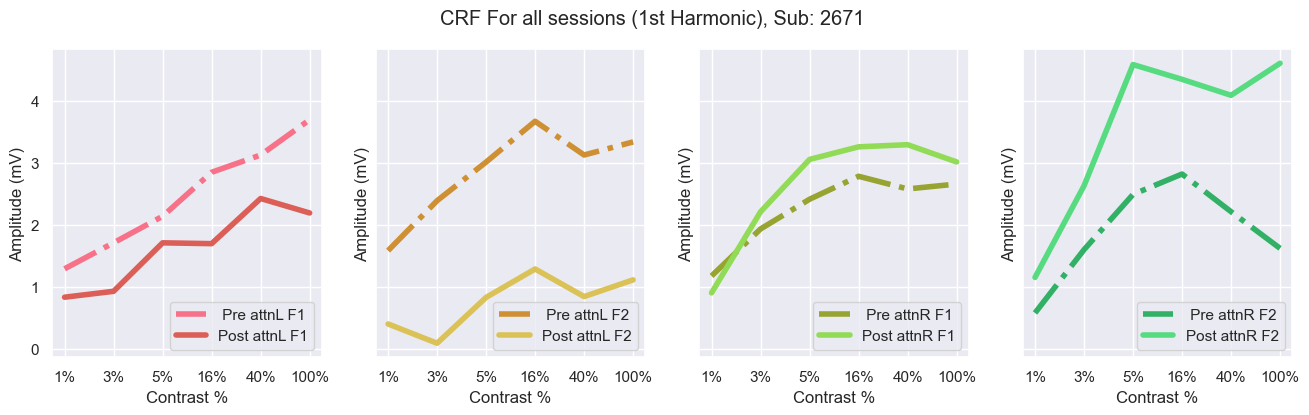

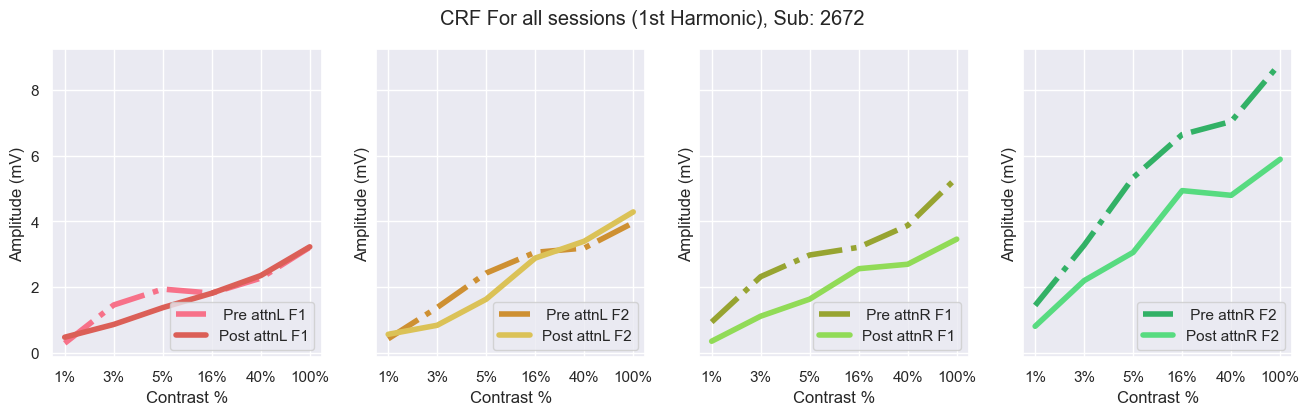

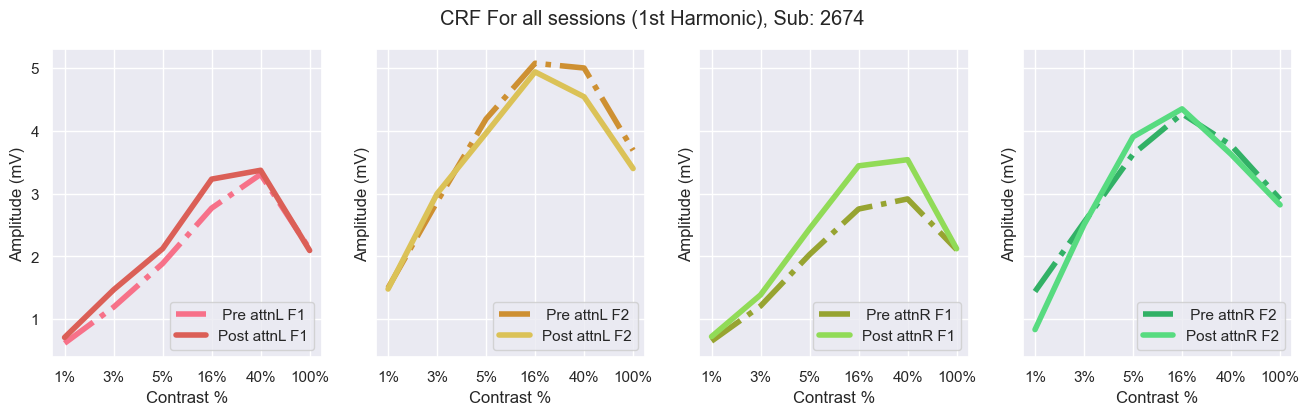

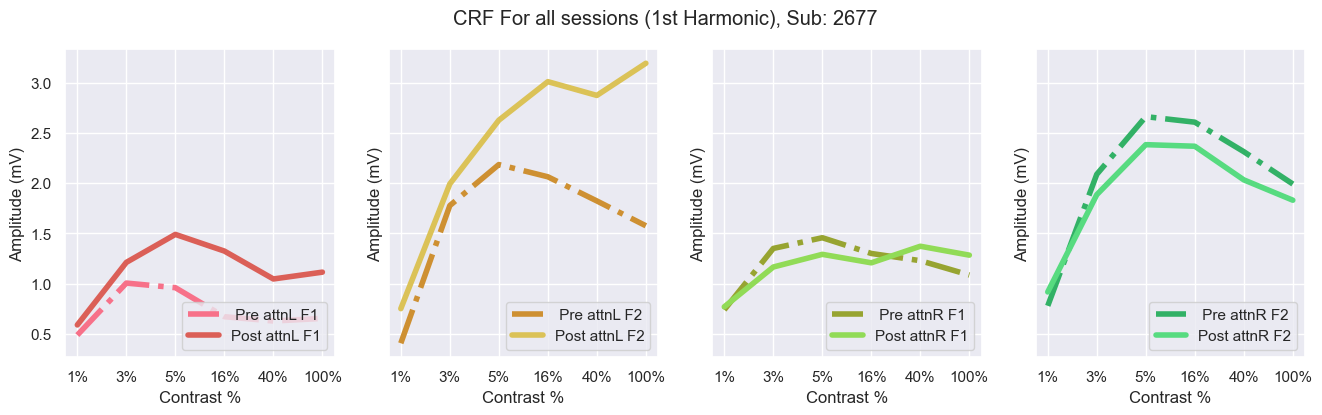

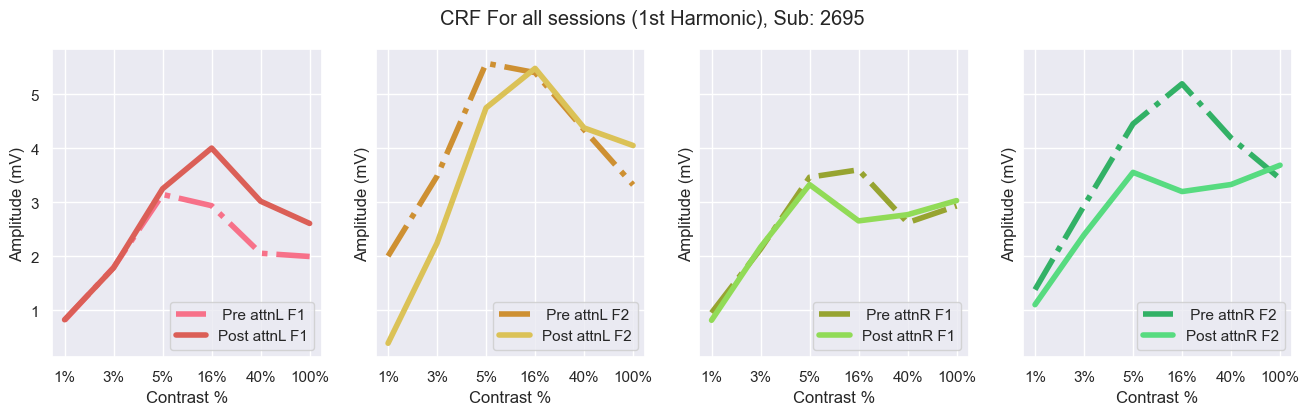

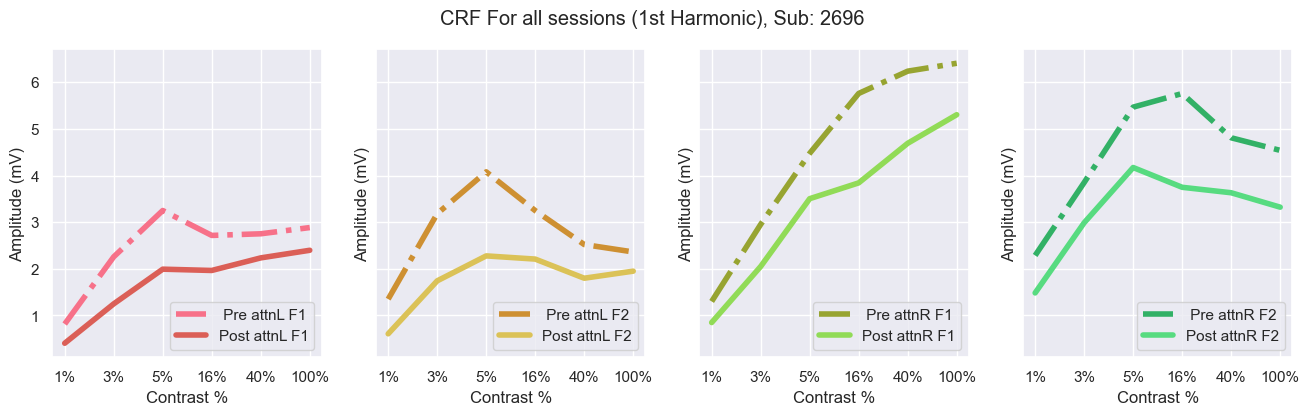

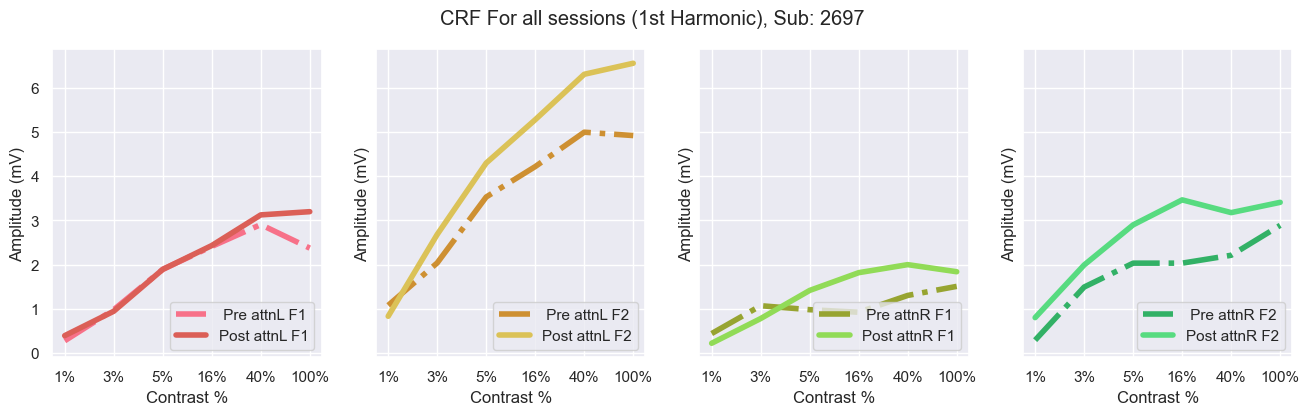

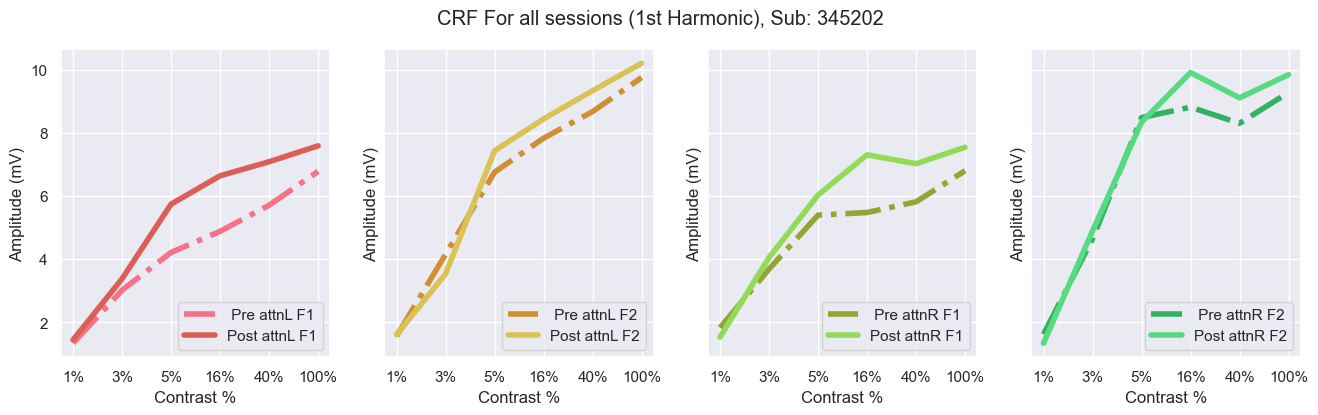

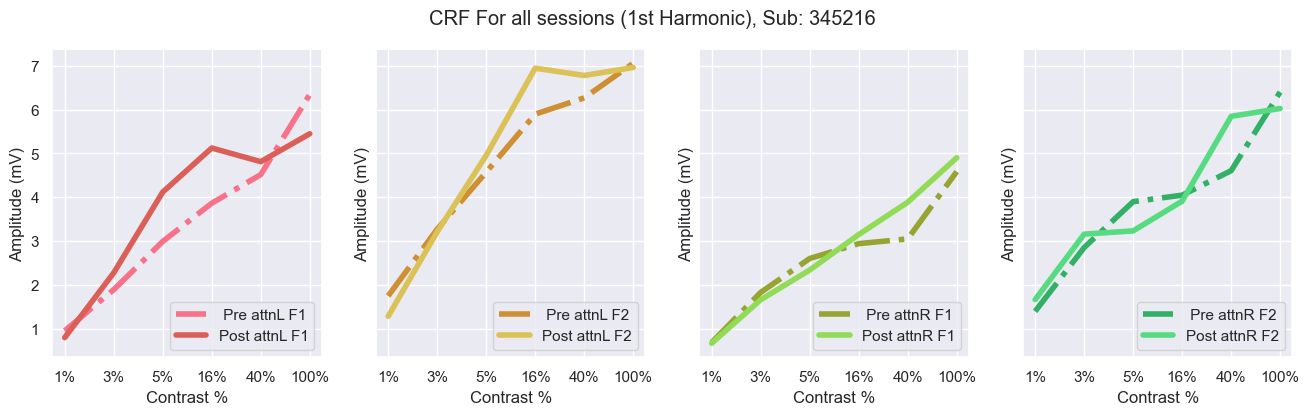

In [30]:
sns.set_theme()
dpi = 150 # img res
for sub_ind in range(NumSubs):
    fig, axs = plt.subplots(1,4,figsize = (16,4), sharey = True )
    for c in range(NumConds):
        ImgName = (f'Sub_{SubName[sub_ind]}_data4F_.png')
        axs[c].plot(avgCRF[c][sub_ind][:6,0], label = f' Pre {dk_labs[c]}', color = x[c], linewidth = 4, linestyle = '-.')
        axs[c].plot(avgCRF[c][sub_ind][:6,1], label = f'Post {dk_labs[c]}', color = y[c], linewidth = 4)
        axs[c].set_xlabel('Contrast %')
        axs[c].set_ylabel('Amplitude (mV)')
        axs[c].legend(loc = 'lower right')
        axs[c].set_xticks(range(len(contrast_levels_labs)))
        axs[c].set_xticklabels(contrast_levels_labs)
        plt.suptitle(f'CRF For all sessions (1st Harmonic), Sub: {SubName[sub_ind]}')
        #ImgPath = os.path.join(newPath, ImgName)
        #plt.savefig(ImgPath, dpi = dpi)
    plt.show()